![](./images/header.png)

# 1. Introduction

In this notebook, we'll start from a time series of Sentinel-2 data, as well as a in-situ database of crop types in Malawi to train a crop type mapping algorithm.

By using the prior knowledge obtained from the previous exercise, we will preprocess the data, extract the data at our in-situ data locations, perform feature extraction and train a Random Forest Classifier.

First, let's explore the in-situ data.

# 2. Explore the in-situ data

By loading our in-situ dataframe, we can assess the variety of the dataset, as well as the location of the fields.


To start, load the in-situ dataset and visualize the amount and variety of training samples.

In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
inpath = Path('/data/users/Public/couchard/Malawi_normalized_data_2023.gpkg')
croptype_df = gpd.read_file(inpath, driver='GPKG')

# Let's visualize the variety of training samples
print(f'Number of points: {len(croptype_df)}')

# Visualize the first few rows
croptype_df.head()

Number of points: 287


,ID,_submissio,sampleID,validityTi,croptype,geometry
0,358643135,2022-11-08,2023_MWI_FRT_POLY_110-15,2022-11-08,soy_soybeans,"POLYGON ((33.82151 -12.91549, 33.82150 -12.915..."
1,358643166,2022-11-08,2023_MWI_FRT_POLY_110-16,2022-11-08,maize,"POLYGON ((33.82303 -12.91504, 33.82270 -12.914..."
2,358643184,2022-11-08,2023_MWI_FRT_POLY_110-17,2022-11-08,maize,"POLYGON ((33.82393 -12.91475, 33.82410 -12.915..."
3,358643197,2022-11-08,2023_MWI_FRT_POLY_110-18,2022-11-08,Mixture three or more,"POLYGON ((33.82384 -12.91675, 33.82346 -12.916..."
4,358643220,2022-11-08,2023_MWI_FRT_POLY_110-19,2022-11-08,Mixture three or more,"POLYGON ((33.82240 -12.91415, 33.82186 -12.913..."


Text(0.5, 0, 'Occurences per crop type in in-situ data')

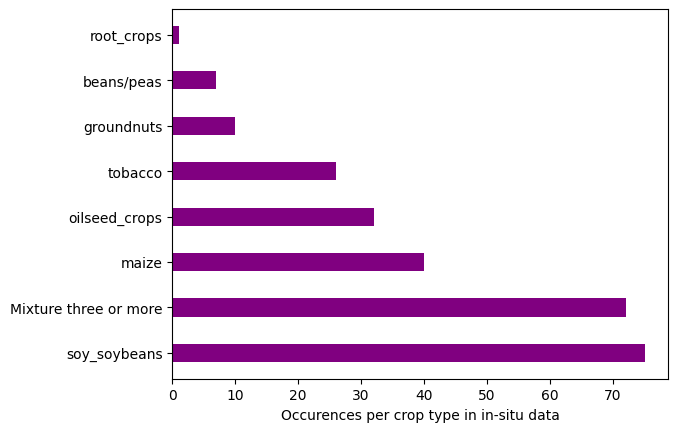

In [3]:
# Here we count the variety in the croptypes available in the dataframe
value_counts = croptype_df['croptype'].value_counts()

# We create a color map for our plot
fig = plt.barh(value_counts.index, value_counts.values, color='purple', height=0.4)
plt.xlabel('Occurences per crop type in in-situ data')

We can see that there is healthy amount of samples for Soy beans, Three crops, Maize, Oilseed and Tobacco. The other croptypes are too scarse in amount of points. When there are not enough data samples, it can be difficult to train a classifier, we will therefore only consider the first 4 most dominant crop types, ignoring the Mixture of threes. Other croptypes are moved to a "Other" class.

In [4]:
# Takes the 3 most common crop types in the data
croptypes = list(value_counts.sort_values(ascending=False).index)[:5]
croptypes.remove('Mixture three or more')

def filter_value(val: str) -> str:
    if val in croptypes:
        return val
    else:
        return 'Other'

croptype_df['croptype'] = croptype_df.croptype.apply(filter_value)
croptype_df.head()

,ID,_submissio,sampleID,validityTi,croptype,geometry
0,358643135,2022-11-08,2023_MWI_FRT_POLY_110-15,2022-11-08,soy_soybeans,"POLYGON ((33.82151 -12.91549, 33.82150 -12.915..."
1,358643166,2022-11-08,2023_MWI_FRT_POLY_110-16,2022-11-08,maize,"POLYGON ((33.82303 -12.91504, 33.82270 -12.914..."
2,358643184,2022-11-08,2023_MWI_FRT_POLY_110-17,2022-11-08,maize,"POLYGON ((33.82393 -12.91475, 33.82410 -12.915..."
3,358643197,2022-11-08,2023_MWI_FRT_POLY_110-18,2022-11-08,Other,"POLYGON ((33.82384 -12.91675, 33.82346 -12.916..."
4,358643220,2022-11-08,2023_MWI_FRT_POLY_110-19,2022-11-08,Other,"POLYGON ((33.82240 -12.91415, 33.82186 -12.913..."


Now that you we have our filterered dataset, evaluate the bounding box of the points.

Using GeoPandas plotting functionalities, create an bounding box enveloping the entirety of our training dataset. To give it a comparison, plot it against the country of Malawi.

Documnetation for those functionalities is available here:
https://geopandas.org/en/stable/docs/user_guide/mapping.html

/tmp/ipykernel_23982/2407674233.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  country_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 36.72222222222221, 'Malawi (pink) and the region of the training data (blue)')

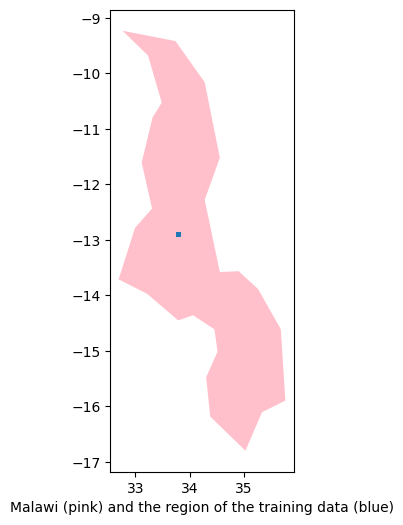

In [5]:
# Loads a dataset containing all the countries borders, and search for Malawi
country_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
malawi = country_df[country_df.name == 'Malawi']

# Compute the envelope
west, south, east, north = croptype_df.total_bounds
from shapely.geometry import box
bounds_df = gpd.GeoDataFrame(geometry=[box(west, south, east, north)], crs=country_df.crs)

# Show the country borders and the envelope
base = malawi.plot(color='pink', figsize=(12, 6))
bounds_df.plot(ax=base)
base.set_xlabel('Malawi (pink) and the region of the training data (blue)')

# 3. Load and preprocess the training data

Using the same Sentinel-2 pre-processing piepeline used in the previous exercise, load the data and perform the same pre-processing operations.

* Compute the cloud mask from the 'SCENECLASSIFICATION' layer.
* Load the 20-m array, mask the clouds, perform 10-daily temporal compositing and linear interpolation.
* Using the same cloud mask, do the same cloud masking, temporal compositing and interpolation with the 10-m array.

No need to upsample the 20-m array.

In [6]:
# Import the necessary python libraries...
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# import custom python functions all defined in separate .py files
# custom functions
from mask import mask_ts
from composite import composite_ts
from interpolate import interpolate_ts

In [7]:
# We start by loading the scene classification layer, containing information about the presence of clouds
# This is delivered at 20m resolution, so we open the 20m resolution file
# infile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/s2_data/36LWL/30/S2-L2A_20m_36LWL-30_32736_2022-10-01_2023-08-01.nc'
infile_20m = '/data/users/Public/couchard/S2_L2A_Malawi_20m.nc'
infile_10m = '/data/users/Public/couchard/S2_L2A_Malawi_10m.nc'

ds = xr.open_dataset(infile_20m)

scl_20 = ds[['SCENECLASSIFICATION']].to_array()
scl_mask_values = [1, 3, 8, 9, 10, 11]
mask_20 = np.logical_not(scl_20.isin(scl_mask_values))

mask_20.attrs = scl_20.attrs.copy()


ts_20 = ds[['B05', 'B06', 'B07', 'B11', 'B12']].to_array()
ts_20_masked = mask_ts(ts_20, mask_20)

# Compoisiting interpolating and upsampling to 10-m resolution
ts_20_comp = composite_ts(ts_20_masked, freq=10, window=20, mode='median')
ts_20_fin = interpolate_ts(ts_20_comp)


In [8]:
ds = xr.open_dataset(infile_10m)

# convert the mask to 10 m resolution
# Get the 10 m bands from the file
ts_10 = ds[['B02', 'B03', 'B04', 'B08']].to_array()

# Apply the mask to the data
ts_10_masked = mask_ts(ts_10, mask_20)

# Apply temporal compositing
ts_10_fin = composite_ts(ts_10_masked, freq=10, window=20, mode='median')


Compute the NDVI value, as done in the previous exercise.

Then, using the <b>xr.concat(...)</b> function, assemble the two preprocessed arrays and the NDVI into a single array.

Docs: https://docs.xarray.dev/en/stable/user-guide/combining.html#concatenate

In [9]:
ts_fin = xr.concat([ts_10_fin, ts_20_fin], dim='variable')

ts_B08 = ts_fin.sel(variable='B08')
ts_B04 = ts_fin.sel(variable='B04')
ndvi = (ts_B08 - ts_B04) / (ts_B08 + ts_B04)

ts_fin = xr.concat([ts_fin, ndvi.expand_dims(dim='variable', axis=0).assign_coords({'variable': ['NDVI']})], dim='variable')
ts_fin

<xarray.DataArray (variable: 10, timestamp: 28, y: 907, x: 985)>
array([[[[9.66000000e+02, 9.47000000e+02, 9.24500000e+02, ...,
          8.66000000e+02, 8.59000000e+02, 8.16000000e+02],
         [9.30000000e+02, 9.53500000e+02, 9.29500000e+02, ...,
          9.61000000e+02, 8.05000000e+02, 7.97000000e+02],
         [8.67000000e+02, 9.35500000e+02, 8.85000000e+02, ...,
          9.21000000e+02, 7.93000000e+02, 8.22000000e+02],
         ...,
         [1.02700000e+03, 1.03950000e+03, 9.85500000e+02, ...,
          8.84000000e+02, 8.79500000e+02, 8.71500000e+02],
         [1.01750000e+03, 9.90000000e+02, 9.54500000e+02, ...,
          8.40000000e+02, 8.47500000e+02, 8.56500000e+02],
         [9.26000000e+02, 9.54000000e+02, 9.76500000e+02, ...,
          8.53000000e+02, 8.45500000e+02, 8.27000000e+02]],

        [[8.82500000e+02, 8.81000000e+02, 8.19500000e+02, ...,
          7.98500000e+02, 7.88000000e+02, 7.50500000e+02],
         [8.18000000e+02, 8.47500000e+02, 8.21000000e+02, ...,
          8.58500000e+02, 7.69500000e+02, 7.31500000e+02],
         [7.31500000e+02, 8.16000000e+02, 8.03000000e+02, ...,
          8.43500000e+02, 7.53000000e+02, 7.51500000e+02],
...
          2.68015176e-01, 2.65306115e-01, 2.63783783e-01],
         [           nan,            nan,            nan, ...,
          2.51305848e-01, 2.44565219e-01, 2.60188073e-01],
         [           nan,            nan,            nan, ...,
          2.33968809e-01, 2.24119529e-01, 2.38143295e-01]],

        [[3.08097273e-01, 3.22643340e-01, 3.20681274e-01, ...,
          3.77178550e-01, 3.42995167e-01, 4.12066758e-01],
         [3.89879525e-01, 3.49397600e-01, 3.43537420e-01, ...,
          3.28964621e-01, 3.48897547e-01, 3.32023561e-01],
         [4.91430759e-01, 3.50173354e-01, 3.73400927e-01, ...,
          3.54140133e-01, 3.81707311e-01, 3.22580636e-01],
         ...,
         [2.31703609e-01, 2.51184821e-01, 3.21309924e-01, ...,
          2.77493596e-01, 2.71428585e-01, 2.60471195e-01],
         [2.46696040e-01, 3.00928444e-01, 3.52053136e-01, ...,
          2.94697911e-01, 2.59306818e-01, 2.61179507e-01],
         [2.25308642e-01, 2.60829479e-01, 2.77955264e-01, ...,
          2.54807681e-01, 2.34068632e-01, 2.36612707e-01]]]],
      dtype=float32)
Coordinates:
  * variable   (variable) object 'B02' 'B03' 'B04' 'B08' ... 'B11' 'B12' 'NDVI'
  * timestamp  (timestamp) datetime64[ns] 2021-10-15 2021-10-25 ... 2022-07-12
  * y          (y) float64 8.578e+06 8.578e+06 8.578e+06 ... 8.569e+06 8.569e+06
  * x          (x) float64 5.82e+05 5.82e+05 5.82e+05 ... 5.918e+05 5.919e+05
Attributes:
    Conventions:  CF-1.9
    description:  
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    title:        
    bounds:       [ 582010. 8569130.  591860. 8578200.]
    resolution:   10.0

In [10]:
del ts_10_fin, ts_20_fin, ts_B04, ts_B08, ndvi, ts_10_masked, ts_20_masked, ts_10, ts_20, ds

# 4. Train a crop type classifier using Machine Learning.

In order to create a crop type map in malawi, we first need to train a Random Forest Classifier with the in-situ data we have available.

In this section, you will have to:

* Sample points within the training data we have at our disposition
* For every point, combine the variable and temporal dimension in to a single dimension using quentiles/percentiles.
* Train de model, evaluate its performance and perform full-tile inference.

### Sample random points from the GeoPandas dataset

From the GeoPandas dataset of croptypes constructed previously in this exercise, sample random points using the `geopandas.GeoSeries.sample_points` function.

Then, sample those points from the array that we just assembled

Docs: https://geopandas.org/en/stable/docs/user_guide/sampling.html

<AxesSubplot:>

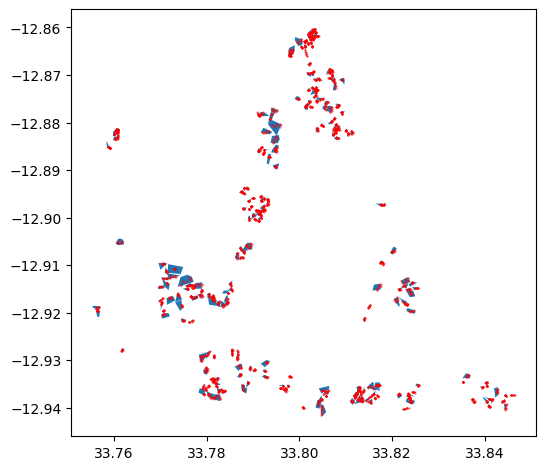

In [11]:
POINTS_PER_FIELD = 10

sampled_points = croptype_df.geometry.sample_points(POINTS_PER_FIELD, rng=42, method='cluster_poisson')
point_labels = croptype_df.croptype.repeat(POINTS_PER_FIELD)

fig, axis = plt.subplots(1, 1, figsize=(6, 6))
croptype_df.plot(ax=axis, legend=True)
sampled_points.plot(ax=axis, c='red', markersize=0.1)

Using the `extract_points` function, extract the sampled points from the sensor array.

In [12]:
from extract import extract_points

training_data = extract_points(ts_fin, sampled_points)
training_data

<xarray.DataArray (sample: 2870, variable: 10, timestamp: 28)>
array([[[7.6500000e+02, 7.6500000e+02, 7.1100000e+02, ...,
         7.6400000e+02, 8.7800000e+02, 6.2200000e+02],
        [1.0640000e+03, 1.0640000e+03, 1.0040000e+03, ...,
         1.0150000e+03, 1.1020000e+03, 8.3900000e+02],
        [1.6360000e+03, 1.7320000e+03, 1.5920000e+03, ...,
         1.2720000e+03, 1.4840000e+03, 1.1950000e+03],
        ...,
        [3.4560000e+03, 3.4560000e+03, 3.3220000e+03, ...,
         3.3270000e+03, 3.4460000e+03, 2.9420000e+03],
        [2.6390000e+03, 2.6020000e+03, 2.6370000e+03, ...,
         2.2250000e+03, 2.2820000e+03, 2.1945000e+03],
        [2.1308321e-01, 1.9366853e-01, 2.3387873e-01, ...,
         4.5826235e-01, 3.9527303e-01, 3.5265440e-01]],

       [[7.9100000e+02, 7.9100000e+02, 7.9400000e+02, ...,
         8.2800000e+02, 9.5400000e+02, 6.8400000e+02],
        [1.1100000e+03, 1.1100000e+03, 1.0980000e+03, ...,
         1.0340000e+03, 1.1720000e+03, 8.5450000e+02],
        [1.8340000e+03, 1.8340000e+03, 1.9200000e+03, ...,
         1.5320000e+03, 1.6280000e+03, 1.2570000e+03],
...
        [4.3005000e+03, 4.3000000e+03, 4.3630000e+03, ...,
         3.7020000e+03, 3.4605000e+03, 3.2190000e+03],
        [3.2335000e+03, 3.1830000e+03, 3.4410000e+03, ...,
         2.7550000e+03, 2.5335000e+03, 2.3120000e+03],
        [1.8896072e-01, 1.9633381e-01, 1.8206771e-01, ...,
         2.0966262e-01,           nan, 2.4132842e-01]],

       [[8.7600000e+02, 8.9100000e+02, 9.0900000e+02, ...,
         1.6450000e+03,           nan, 6.0900000e+02],
        [1.1290000e+03, 1.1520000e+03, 1.2100000e+03, ...,
         1.7470000e+03,           nan, 7.5000000e+02],
        [1.6310000e+03, 1.6660000e+03, 1.7880000e+03, ...,
         1.9385000e+03,           nan, 1.0280000e+03],
        ...,
        [4.3005000e+03, 4.3000000e+03, 4.3630000e+03, ...,
         3.7020000e+03, 3.4605000e+03, 3.2190000e+03],
        [3.2335000e+03, 3.1830000e+03, 3.4410000e+03, ...,
         2.7550000e+03, 2.5335000e+03, 2.3120000e+03],
        [1.8896072e-01, 1.9633381e-01, 1.8206771e-01, ...,
         2.0966262e-01,           nan, 2.4132842e-01]]], dtype=float32)
Coordinates:
  * variable   (variable) object 'B02' 'B03' 'B04' 'B08' ... 'B11' 'B12' 'NDVI'
  * timestamp  (timestamp) datetime64[ns] 2021-10-15 2021-10-25 ... 2022-07-12
  * sample     (sample) int64 0 1 2 3 4 5 6 ... 2864 2865 2866 2867 2868 2869
Attributes:
    Conventions:  CF-1.9
    description:  
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    title:        
    bounds:       [ 582010. 8569130.  591860. 8578200.]
    resolution:   10.0

### Compute additional features using percentiles

One of the most interesting aspect of Remote Sensing when using Machine Learning is the temporal dimension. Different objects visible on the surface of earth will have a different evolution of with time. The most notable examples are usually in vegetation, were seasonal properties exists depending on the region and the species. Looking at the temporal dimension can therefore improve classification tasks. Recent research push Deep Learning techniques to analyse those temporal characteristics and use the most of it.

Unfortunately, analyzing the temporal dimension obviously implies the use of another dimension, increasing tremendously the computational power requirements. This does not help the realization of large Remote Sensing projects, which already suffer from the very large quantities of data to process.

There is a large variety of techniques that can be used to mitigate the issue by combining the `variable` and the `time` dimensions into one. Here, we will use percentiles/quantiles computed on the `time` dimension. 

Using the `band_percentile` function, extract the following percentiles:

* For the Red, Green, Blue and NIR bands, we compute the 10th, 50th and 90th percentiles.
* For the NDVI, we compute the 10th, 25th, 50th, 75th and 90th percentiles.
* For the other bands, we only keep the 50th percentile (median)

In [13]:
%load_ext autoreload

In [14]:
%autoreload 2
from features import band_percentile

band_percentiles = {
    'B02': [0.1, 0.5, 0.9],
    'B03': [0.1, 0.5, 0.9],
    'B04': [0.1, 0.5, 0.9],
    'B08': [0.1, 0.5, 0.9],
    'NDVI': [0.1, 0.25, 0.5, 0.75, 0.9],
    'B05': [0.5],
    'B06': [0.5],
    'B07': [0.5],
    'B11': [0.5],
    'B12': [0.5]
}

training_data_df = band_percentile(training_data, band_percentiles).to_dataframe(
        name='features', dim_order=['sample', 'features']
).unstack()
training_data_df

features                                                           \
features  B02-0.1 B02-0.5 B02-0.9 B03-0.1 B03-0.5 B03-0.9  B04-0.1 B04-0.5   
sample                                                                       
0          613.45   690.5  1679.2  843.40  1039.5  1722.0   817.10  1581.5   
1          611.70   736.5  1550.0  825.25  1098.0  1793.6   825.65  1737.0   
2          642.45   777.0  1234.6  892.90  1132.0  1753.0   992.00  1817.0   
3          598.50   783.0  1421.0  759.40  1126.0  1698.8   903.10  1795.0   
4          541.20   785.0  1272.8  790.25  1148.0  1634.2  1036.00  1699.5   
...           ...     ...     ...     ...     ...     ...      ...     ...   
2865       614.00   886.0  1356.0  782.00  1184.0  1350.0   753.00  1612.0   
2866       594.00   897.0  1266.0  750.00  1188.0  1356.0   732.00  1560.0   
2867       609.00   888.0  1336.0  750.00  1210.0  1408.0   782.00  1631.0   
2868       609.00   888.0  1336.0  750.00  1210.0  1408.0   782.00  1631.0   
2869       609.00   888.0  1336.0  750.00  1210.0  1408.0   782.00  1631.0   

                          ...                                          \
features B04-0.9 B08-0.1  ...  NDVI-0.1 NDVI-0.25  NDVI-0.5 NDVI-0.75   
sample                    ...                                           
0         1852.6  2522.2  ...  0.211589  0.228051  0.318170  0.457718   
1         1958.2  2382.0  ...  0.131182  0.139498  0.245574  0.458325   
2         2082.0  2428.3  ...  0.123558  0.130064  0.230883  0.434286   
3         2121.8  2361.3  ...  0.126040  0.128695  0.205809  0.471780   
4         2373.0  2188.2  ...  0.116590  0.120381  0.190219  0.448742   
...          ...     ...  ...       ...       ...       ...       ...   
2865      1898.0  2582.0  ...  0.211884  0.221129  0.267606  0.524130   
2866      1901.0  2323.0  ...  0.172929  0.184978  0.209726  0.457323   
2867      1938.5  2177.0  ...  0.182068  0.188961  0.209663  0.409518   
2868      1938.5  2177.0  ...  0.182068  0.188961  0.209663  0.409518   
2869      1938.5  2177.0  ...  0.182068  0.188961  0.209663  0.409518   

                                                                        \
features  NDVI-0.9      B05-0.5      B06-0.5      B07-0.5      B11-0.5   
sample                                                                   
0         0.617301  1929.500000  2782.083374  3023.208374  3421.833374   
1         0.531925  2157.000000  2559.000000  2724.500000  3651.666626   
2         0.483597  2190.000000  2491.500000  2741.500000  3820.000000   
3         0.515162  2190.000000  2491.500000  2741.500000  3820.000000   
4         0.494604  2112.833374  2435.041626  2583.916626  3767.958374   
...            ...          ...          ...          ...          ...   
2865      0.584428  1732.000000  2346.500000  2569.000000  3283.500000   
2866      0.533011  1849.500000  2467.000000  2770.916626  3259.500000   
2867      0.513303  1732.000000  2346.500000  2569.000000  3283.500000   
2868      0.513303  1732.000000  2346.500000  2569.000000  3283.500000   
2869      0.513303  1732.000000  2346.500000  2569.000000  3283.500000   

                       
features      B12-0.5  
sample                 
0         2471.666626  
1         2612.583374  
2         2825.000000  
3         2825.000000  
4         3001.333374  
...               ...  
2865      2235.500000  
2866      2217.000000  
2867      2235.500000  
2868      2235.500000  
2869      2235.500000  

[2870 rows x 22 columns]

### Balance the dataset ⚖️

Because the "Other" class is very dominant in our dataset, we will use a small feature from the `imbalance-learn` package, allowing to better equilibrate the dataset and have the same number of class for each croptype.

Having an equilibrated dataset is important as it prevents the model to overfit on a certain class.

Initialize a `RandomUnderSampler` object and perform resampling on the `train_data_df` and `point_labels` datasets.  

In [15]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X, y = undersampler.fit_resample(training_data_df, point_labels)

### AI Time 💃 Let's train a Random Forest Classifier

Using the sklearn framework, let's train a random forest classifier. Before fitting the data within our model, we still need to do a final step: separating the data in two sets: the <b>training</b> data and the <b>validation</b> data. In order to prove that the model generalizes well on new samples, we want to test the performance of our model on different data than the one that was used to train it.

This split can be easily done from our DataFrame using the `sklearn.model_selection.train_test_split` function.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Once split the training dataset split, train the model with it

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


# Let's perform dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)


model = CatBoostClassifier()

# We train our model
model.fit(X_train, y_train, logging_level='Silent')

### Evoluate model performance

To evaluate the model performance, we perform prediction on the validation data that we previously split from. Then, we can use the `sklearn.metrics.accuracy_score` and `sklearn.metrics.confusion_matrix` functions.

The accuracy score denotates how many validation examples were correctly labelled by the model, while the confusion matrix shows where the prediction errors are made by comparing in-situ crop types with crop types predicted by the model.

Docs: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

0.6884615384615385


([<matplotlib.axis.YTick at 0x7f49b1c67d60>,
 [Text(0, 0.5, 'Other'),
  Text(0, 1.5, 'maize'),
  Text(0, 2.5, 'oilseed_crops'),
  Text(0, 3.5, 'soy_soybeans'),
  Text(0, 4.5, 'tobacco')])

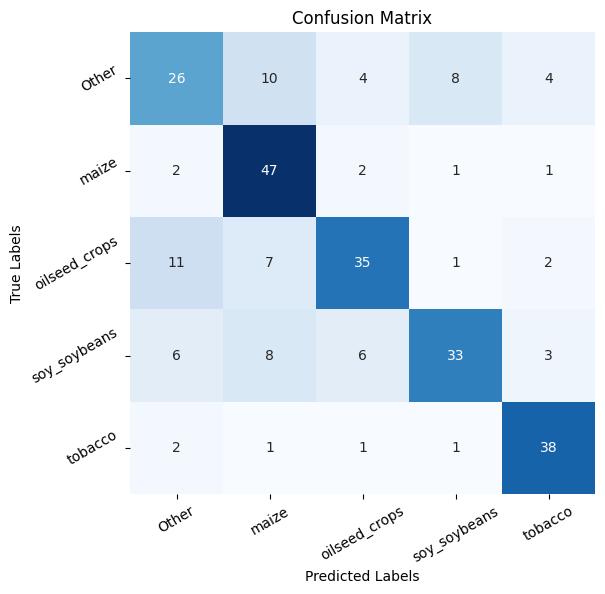

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# First, we predict the result the model on the validation data
y_pred = model.predict(X_test)

# Compute the accuracy score, the confusion matrix and the plot the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(accuracy)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(cm)) + 0.5, labels=model.classes_, rotation=30)  # Replace labels with your class names
plt.yticks(np.arange(len(cm)) + 0.5, labels=model.classes_, rotation=30)  # Replace labels with your class names

### Perform inference for crop type mapping 🗺️

Now that our model is trained, let's perform inference on the entirety of our downloaded data.

First, compute the same quantiles as done for the training data, but this time on the entire data cube instead of the samples datacube. Then combine those quantile cubes into a single one using the xr.concat method.

In [18]:
import dask
from dask.diagnostics.progress import ProgressBar

dask.config.set(scheduler='multiprocessing')

with ProgressBar():
    ts_fin = ts_fin.chunk({'x': 100, 'y': 100, 'timestamp': -1, 'variable': -1})

    ts_inference = band_percentile(ts_fin, band_percentiles).compute()
    inference_df = ts_inference.to_dataframe(
        name='features', dim_order=['x', 'y', 'features']
    ).unstack()

inference_df

[########################################] | 100% Completed | 220.19 s


features                                                    \
features            B02-0.1 B02-0.5 B02-0.9 B03-0.1  B03-0.5 B03-0.9  B04-0.1   
x        y                                                                      
582015.0 8578195.0   524.00  739.75  1077.6  796.00  1022.75  1368.0   905.60   
         8578185.0   502.00  688.00  1080.0  782.00   956.50  1429.8   822.30   
         8578175.0   400.40  611.00  1049.8  690.00   835.25  1334.0   642.00   
         8578165.0   380.90  657.50  1080.8  636.50   881.50  1348.0   652.00   
         8578155.0   400.25  749.25  1143.0  709.90  1011.50  1410.0   655.35   
...                     ...     ...     ...     ...      ...     ...      ...   
591855.0 8569175.0   518.00  928.00  1190.0  860.00  1369.00  1628.0  1046.00   
         8569165.0   469.00  887.50  1070.0  747.00  1360.00  1484.0   924.00   
         8569155.0   454.70  871.75  1006.5  712.75  1310.50  1420.5   872.10   
         8569145.0   438.25  852.50   979.8  685.30  1293.00  1375.6   897.85   
         8569135.0   439.05  816.50   977.7  695.65  1238.00  1381.5   953.65   

                                             ...                      \
features            B04-0.5 B04-0.9 B08-0.1  ...  NDVI-0.1 NDVI-0.25   
x        y                                   ...                       
582015.0 8578195.0  1354.00  1564.1  1854.9  ...  0.148686  0.156987   
         8578185.0  1170.50  1433.3  1729.8  ...  0.193134  0.201860   
         8578175.0   955.75  1290.2  2046.2  ...  0.328520  0.342900   
         8578165.0   995.75  1350.5  2092.4  ...  0.293075  0.310484   
         8578155.0  1262.00  1535.6  1958.8  ...  0.174045  0.207650   
...                     ...     ...     ...  ...       ...       ...   
591855.0 8569175.0  2007.00  2449.0  2522.0  ...  0.115547  0.126257   
         8569165.0  1710.00  2392.0  2062.0  ...  0.104660  0.121166   
         8569155.0  1480.00  2397.8  1990.4  ...  0.096601  0.118474   
         8569145.0  1472.50  2336.6  2021.8  ...  0.100040  0.120984   
         8569135.0  1550.50  2300.8  2058.0  ...  0.108420  0.123755   

                                                                        \
features            NDVI-0.5 NDVI-0.75  NDVI-0.9      B05-0.5  B06-0.5   
x        y                                                               
582015.0 8578195.0  0.292651  0.435244  0.505476  1539.599976  2246.75   
         8578185.0  0.289730  0.506737  0.556391  1539.599976  2246.75   
         8578175.0  0.397782  0.632591  0.663794  1446.625000  2549.00   
         8578165.0  0.338582  0.609389  0.635077  1446.625000  2549.00   
         8578155.0  0.395929  0.639358  0.682243  1652.000000  2726.00   
...                      ...       ...       ...          ...      ...   
591855.0 8569175.0  0.242841  0.381918  0.467881  2119.000000  2871.00   
         8569165.0  0.245995  0.362032  0.457109  2119.000000  2871.00   
         8569155.0  0.262127  0.415071  0.507394  1887.875000  2725.75   
         8569145.0  0.260684  0.402624  0.500542  1887.875000  2725.75   
         8569135.0  0.237378  0.385167  0.462376  1940.375000  2657.75   

                                                   
features             B07-0.5      B11-0.5 B12-0.5  
x        y                                         
582015.0 8578195.0  2563.000  3105.125000  2046.0  
         8578185.0  2563.000  3105.125000  2046.0  
         8578175.0  2769.000  2628.500000  1762.0  
         8578165.0  2769.000  2628.500000  1762.0  
         8578155.0  3186.125  2645.699951  1795.0  
...                      ...          ...     ...  
591855.0 8569175.0  3048.625  3195.500000  2298.0  
         8569165.0  3048.625  3195.500000  2298.0  
         8569155.0  2860.250  3038.000000  2142.5  
         8569145.0  2860.250  3038.000000  2142.5  
         8569135.0  2820.000  3183.500000  2211.0  

[893395 rows x 22 columns]

As done previously, transform the entire datacube into a single dataset, then perform model inference using the `model.predict` method.

In [19]:
prediction = model.predict(inference_df)
prediction

array([['maize'],
       ['maize'],
       ['soy_soybeans'],
       ...,
       ['Other'],
       ['Other'],
       ['Other']], dtype=object)

### Map visualization 🔎

Let's reconstruct the map from the given prediction. Let's map every class to a tuple giving a color.

In [20]:
# Blue
OTHER_COLOR = (48, 110, 209)

# Yellow
MAIZE = (204, 164, 55)

# Purple
SOY_BEANS = (163, 5, 158)

# Olive color
OILSEEDS_CROPS = (219, 245, 91)

# Brown
TOBACCO = (107, 55, 55)

color_map = {
    'tobacco': TOBACCO,
    'oilseed_crops': OILSEEDS_CROPS,
    'soy_soybeans': SOY_BEANS,
    'Other': OTHER_COLOR,
    'maize': MAIZE
}

def map_class_to_color(class_value: str):
    # Returns the color of the given class, and black color if unknown
    return color_map.get(class_value, (0, 0, 0))

vectorized_map = np.vectorize(map_class_to_color)

rgb_array = np.array(vectorized_map(prediction)).squeeze().reshape(
    3, ts_inference.shape[1], ts_inference.shape[0]
)

rgb_array = np.moveaxis(rgb_array, 0, -1)

prediction_array = xr.DataArray(
    rgb_array,
    dims=['x', 'y', 'channels'],
    coords={
        'x': ts_inference.coords['x'],
        'y': ts_inference.coords['y'],
        'channels': ['R', 'G', 'B']
    }
)

prediction_array.shape

(985, 907, 3)

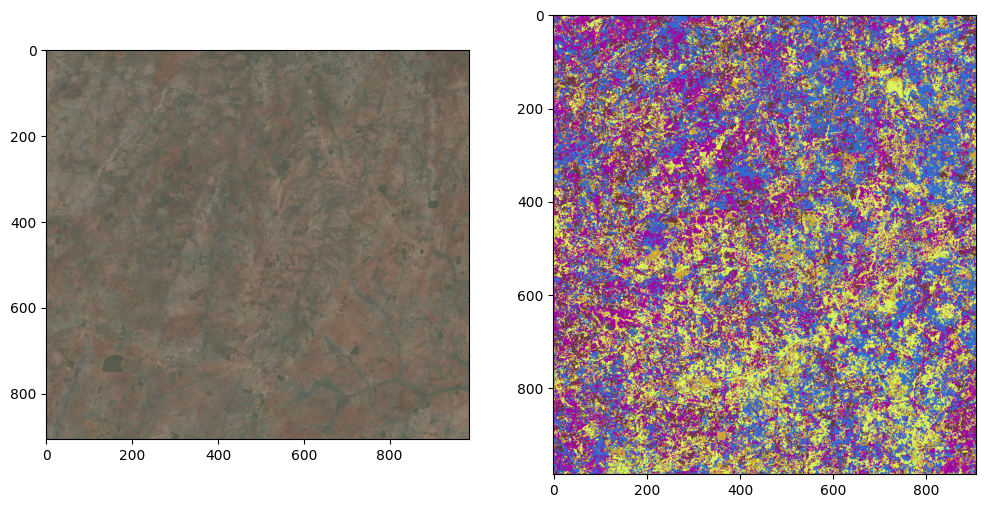

In [21]:
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

rgb = (ts_inference.sel(features=['B04-0.5', 'B03-0.5', 'B02-0.5']) / 1e4) ** .4

axis[0].imshow(rgb)
axis[1].imshow(rgb_array)